In [56]:
!pip install catboost
# !pip install probatus
# !pip install numba==0.56.0
!pip install BorutaShap
!pip install scikit-learn==1.1.3
!pip install mlflow
!pip install imbalanced-learn
!pip install optuna

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import TimeSeriesSplit, BaseCrossValidator
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from collections import Counter
from tqdm import tqdm

from BorutaShap import BorutaShap
# from probatus.feature_elimination import ShapRFECV
import os
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

from imblearn.under_sampling import NearMiss
import shap
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [156]:
data_fac = pd.read_parquet('/kaggle/input/dataset-hack-nizhniy-novgorod/factor_analysis.parquet')
data_fac

,report_date,feature_name,not_null_percent,mode_frequency,ind_gini,cor_group
0,2021-02-01,col1271,0.000000,NaN,0.132,8.0
1,2021-02-01,col2271,0.083333,0.222222,0.006,1.0
2,2021-02-01,col245,0.000000,NaN,0.022,12.0
3,2021-02-01,col2548,0.027778,0.333333,0.172,1.0
4,2021-02-01,col336,0.000000,NaN,0.144,1.0
...,...,...,...,...,...,...
66570,2022-11-01,col1707,0.000000,NaN,0.800,54.0
66571,2022-12-01,col1698,0.000000,NaN,0.308,70.0
66572,2022-12-01,col1806,0.000000,NaN,0.444,72.0
66573,2023-01-01,col1708,0.000000,NaN,0.800,54.0


### Применим факторный анализ

In [157]:
data_fac['report_date'].unique()

array([datetime.date(2021, 2, 1), datetime.date(2021, 3, 1),
       datetime.date(2021, 4, 1), datetime.date(2021, 5, 1),
       datetime.date(2021, 6, 1), datetime.date(2021, 7, 1),
       datetime.date(2021, 8, 1), datetime.date(2021, 9, 1),
       datetime.date(2021, 10, 1), datetime.date(2021, 11, 1),
       datetime.date(2021, 12, 1), datetime.date(2022, 1, 1),
       datetime.date(2022, 2, 1), datetime.date(2022, 3, 1),
       datetime.date(2022, 4, 1), datetime.date(2022, 5, 1),
       datetime.date(2022, 6, 1), datetime.date(2022, 7, 1),
       datetime.date(2022, 8, 1), datetime.date(2022, 9, 1),
       datetime.date(2022, 10, 1), datetime.date(2022, 11, 1),
       datetime.date(2022, 12, 1), datetime.date(2023, 1, 1),
       datetime.date(2023, 2, 1)], dtype=object)

In [158]:
list(data_fac['report_date'].sort_values(ascending=True).unique())[-6:]

[datetime.date(2022, 9, 1),
 datetime.date(2022, 10, 1),
 datetime.date(2022, 11, 1),
 datetime.date(2022, 12, 1),
 datetime.date(2023, 1, 1),
 datetime.date(2023, 2, 1)]

In [159]:
features = data_fac[
    (data_fac['ind_gini']>0.05)
    & (data_fac['not_null_percent'] > 0.1)
    & (data_fac['mode_frequency'] < 0.8)
    & (~data_fac['report_date'].isin(list(data_fac['report_date'].sort_values(ascending=True).unique())[-3:]))
]['feature_name'].unique()

len(features)

507

In [153]:
df = pd.read_csv(
    '/kaggle/input/dataset-hack-nizhniy-novgorod/train_dataset_.csv',
    usecols = list(features) + ['target', 'report_date', 'client_id']
)
df['report_date'] = pd.to_datetime(df['report_date'])


df = df[df.columns[~df.columns.isin(list(df.select_dtypes('object').columns)+['col1454'])]]
# df = df[df.columns[df.columns.isin(list(df.select_dtypes('object').columns)+['target', 'report_date', 'client_id'])]]
# df = df[df.columns[~df.columns.isin(['col1454'])]]

try:
    df = df.drop(columns = ['col1454'])
except:
    pass

df.head()

,report_date,client_id,target,col128,col248,col252,col256,col260,col268,col272,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [154]:
df[df['report_date']=='2022-11-01']['target'].value_counts()

target
0    926
1     21
Name: count, dtype: int64

[I 2023-09-09 11:56:58,636] Trial 5 finished with value: 0.7750743691851022 and parameters: {'depth': 14, 'l2_leaf_reg': 2}. Best is trial 3 with value: 0.7842199930796594.


[CV] END ................................ score: (test=0.797) total time=29.1min


[I 2023-09-09 12:00:33,785] Trial 6 finished with value: 0.7750743691851022 and parameters: {'depth': 14, 'l2_leaf_reg': 2}. Best is trial 3 with value: 0.7842199930796594.


[CV] END ................................ score: (test=0.797) total time=24.8min


In [108]:
# df.select_dtypes('object').columns
# for col in df.select_dtypes('object').columns:
#     print('*' * 100)
#     display(df[col].value_counts())
#     print(df[col].mode()[0])
# #     df[col] = df[col].fillna(df[col].mode()[0])
    
# df.info(show_counts = True, verbose = True)

In [109]:
# # df.info(show_counts = True, verbose=True)
# df['client_id'].value_counts().plot(kind= 'bar')

In [110]:
df['target'].value_counts()

target
0    14020
1      436
Name: count, dtype: int64

In [111]:
print(len(list(df['report_date'].sort_values(ascending=True).unique())))
list(df['report_date'].sort_values(ascending=True).unique())[-3:]

25


[Timestamp('2022-12-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2023-02-01 00:00:00')]

In [112]:
df = df.sort_values(by=['report_date'])
df.head(5)

,report_date,client_id,target,col128,col248,col252,col256,col260,col268,col272,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
9374,2021-02-01,491,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
2289,2021-02-01,359,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
8035,2021-02-01,637,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
2286,2021-02-01,2895,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
2758,2021-02-01,3302,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261


In [113]:
df_test = df[df['report_date'].isin(list(df['report_date'].sort_values(ascending=True).unique())[-6:])]
df_train = df[~df['report_date'].isin(list(df['report_date'].sort_values(ascending=True).unique())[-6:])]

df_val = df_test[~df_test['report_date'].isin(list(df_test['report_date'].sort_values(ascending=True).unique())[-3:])]
df_test = df_test[df_test['report_date'].isin(list(df_test['report_date'].sort_values(ascending=True).unique())[-3:])]


display(df_train['report_date'].unique())
display(df_val['report_date'].unique())
display(df_test['report_date'].unique())

<DatetimeArray>
['2021-02-01 00:00:00', '2021-03-01 00:00:00', '2021-04-01 00:00:00',
 '2021-05-01 00:00:00', '2021-06-01 00:00:00', '2021-07-01 00:00:00',
 '2021-08-01 00:00:00', '2021-09-01 00:00:00', '2021-10-01 00:00:00',
 '2021-11-01 00:00:00', '2021-12-01 00:00:00', '2022-01-01 00:00:00',
 '2022-02-01 00:00:00', '2022-03-01 00:00:00', '2022-04-01 00:00:00',
 '2022-05-01 00:00:00', '2022-06-01 00:00:00', '2022-07-01 00:00:00',
 '2022-08-01 00:00:00']
Length: 19, dtype: datetime64[ns]

<DatetimeArray>
['2022-09-01 00:00:00', '2022-10-01 00:00:00', '2022-11-01 00:00:00']
Length: 3, dtype: datetime64[ns]

<DatetimeArray>
['2022-12-01 00:00:00', '2023-01-01 00:00:00', '2023-02-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [114]:
df_train[df_train.select_dtypes('object').columns] = df_train[df_train.select_dtypes('object').columns].astype(str)
df_val[df_val.select_dtypes('object').columns] = df_val[df_val.select_dtypes('object').columns].astype(str)
df_test[df_test.select_dtypes('object').columns] = df_test[df_test.select_dtypes('object').columns].astype(str)


In [115]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled_nm1, y_resampled = rus.fit_resample(df_train, df_train['target'])
# y_resampled.value_counts()

# X_resampled_nm1['target'] = y_resampled

### Отбор фич с помощью RFECV

In [116]:


class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

btscv = BlockedTimeSeriesSplit(n_splits=4, train_size=3, test_size=3, col_date = pd.concat([df_train, df_val])['report_date'])

In [117]:
from sklearn.feature_selection import RFECV
del_col = ['target', 'report_date', 'client_id']

rfecv = RFECV(
    estimator= CatBoostClassifier(verbose = 0, iterations=100, eval_metric='AUC', random_seed = 12345),
    step=0.1,
    cv=btscv,
    scoring="roc_auc",
    min_features_to_select=40,
#     n_jobs=2,
    verbose = 3
)
rfecv.fit(pd.concat([df_train, df_val]).drop(columns = del_col), pd.concat([df_train, df_val])['target'])

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 507 features.
Fitting estimator with 457 features.
Fitting estimator with 407 features.
Fitting estimator with 357 features.
Fitting estimator with 307 features.
Fitting estimator with 257 features.
Fitting estimator with 207 features.
Fitting estimator with 157 features.
Fitting estimator with 107 features.
Fitting estimator with 57 features.
Fitting estimator with 507 features.
Fitting estimator with 457 features.
Fitting estimator with 407 features.
Fitting estimator with 357 features.
Fitting estimator with 307 features.
Fitting estimator with 257 features.
Fitting estimator with 207 features.
Fitting estimator with 157 features.
Fitting estimator with 107 features.
Fitting estimator with 57 features.
Fitting estimator with 507 features.
Fitting estimator with 457 features.
Fitting estimator with 407 features.
Fitting estimator with 357 features.
Fitting estimator with 307 features.
Fitting estimator with 257 features.
Fitting estimator with 207 features.
Fit

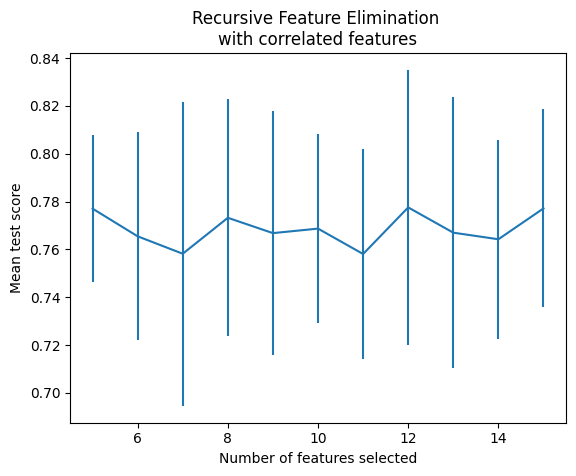

In [118]:


n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(5, n_scores + 5),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)

plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [120]:
good_features = rfecv.get_feature_names_out(df_train.drop(columns = del_col).columns)
good_features

array(['col128', 'col248', 'col252', 'col256', 'col260', 'col268',
       'col272', 'col276', 'col280', 'col288', 'col292', 'col296',
       'col304', 'col308', 'col312', 'col316', 'col320', 'col328',
       'col332', 'col336', 'col344', 'col348', 'col352', 'col356',
       'col372', 'col376', 'col380', 'col388', 'col392', 'col396',
       'col400', 'col404', 'col408', 'col412', 'col416', 'col420',
       'col424', 'col428', 'col432', 'col436', 'col440', 'col444',
       'col452', 'col456', 'col476', 'col499', 'col500', 'col503',
       'col504', 'col507', 'col508', 'col511', 'col512', 'col620',
       'col624', 'col636', 'col640', 'col644', 'col648', 'col652',
       'col656', 'col660', 'col664', 'col668', 'col672', 'col676',
       'col680', 'col684', 'col688', 'col692', 'col696', 'col700',
       'col704', 'col708', 'col712', 'col716', 'col720', 'col724',
       'col728', 'col732', 'col736', 'col740', 'col744', 'col748',
       'col752', 'col756', 'col764', 'col768', 'col772', 'col8

In [121]:
df_train = df_train[list(good_features)+del_col]
df_val = df_val[list(good_features)+del_col]
df_test = df_test[list(good_features)+del_col]
df_train.head()

,col128,col248,col252,col256,col260,col268,col272,col276,col280,col288,...,col2657,col2658,col2659,col2660,col2661,col2662,col2663,target,report_date,client_id
9374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256261,0,2021-02-01,491
2289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256261,0,2021-02-01,359
8035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256261,0,2021-02-01,637
2286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256261,0,2021-02-01,2895
2758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256261,0,2021-02-01,3302


### Обучение модели

In [46]:
df_train['target'].value_counts()[0]/df_train['target'].value_counts()[1]

26.2475884244373

In [47]:
# null_counts = df_train.isna().sum()
# display(null_counts)
# # удаление колонок, в которых количество пропусков равно 10
# display(len(null_counts[null_counts*100/df_train.shape[0] > 40].index))
# df_train_v2 = df_train.drop(null_counts[null_counts*100/df_train.shape[0] > 40].index, axis=1)
# df_train_v2.shape

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[W 2023-09-09 06:58:20,136] Trial 3 failed with parameters: {'depth': 12, 'subsample': 0.8677283137503793, 'colsample_bylevel': 0.9020058892222065, 'l2_leaf_reg': 5, 'min_data_in_leaf': 56} because of the following error: ZMQError('Socket operation on non-socket').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 26, in objective
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 1

[CV] END ................................ score: (test=0.887) total time=10.3min

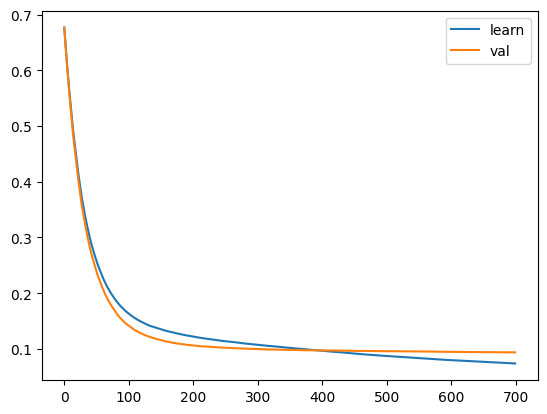

CPU times: user 1min 55s, sys: 708 ms, total: 1min 55s
Wall time: 30.1 s


In [56]:
%%time
model = CatBoostClassifier(
    verbose = 0,
    learning_rate=0.01,
    eval_metric='AUC',
#     depth = 10,
    iterations = 700,
    random_seed = 12345
) #iterations=100,

del_col = ['target', 'report_date', 'client_id']


pool_train = Pool(
    df_train.drop(columns = del_col),
    label = df_train['target'],
    cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
)

pool_val = Pool(
    df_val.drop(columns = del_col),
    label = df_val['target'],
    cat_features = list(df_val.drop(columns = del_col).select_dtypes('object').columns)
)



model.fit(pool_train, eval_set=pool_val,plot=True)
# model.get_feature_importance(
#     data=pool_train,
#     reference_data=pool_val,
# )

plt.plot(
    range(0, len(model.evals_result_['learn']['Logloss'])),
    model.evals_result_['learn']['Logloss'],
    label='learn'
)
plt.plot(
    range(0, len(model.evals_result_['learn']['Logloss'])),
    model.evals_result_['validation']['Logloss'],
    label='val'
)
plt.legend()
plt.show()

In [57]:
# depth = 10
X_test_good = df_val.drop(columns = del_col)
y_test = df_val['target']

print('roc_auc: ',roc_auc_score(y_test, model.predict_proba(X_test_good)[:, 1]))
precision, recall,_ = precision_recall_curve(y_test, model.predict_proba(X_test_good)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)

roc_auc:  0.8041689128481582
pr_auc:  0.14691586298374962
[CV] END ................................ score: (test=0.838) total time= 4.5min


### Важность признаков с помощью Shap 

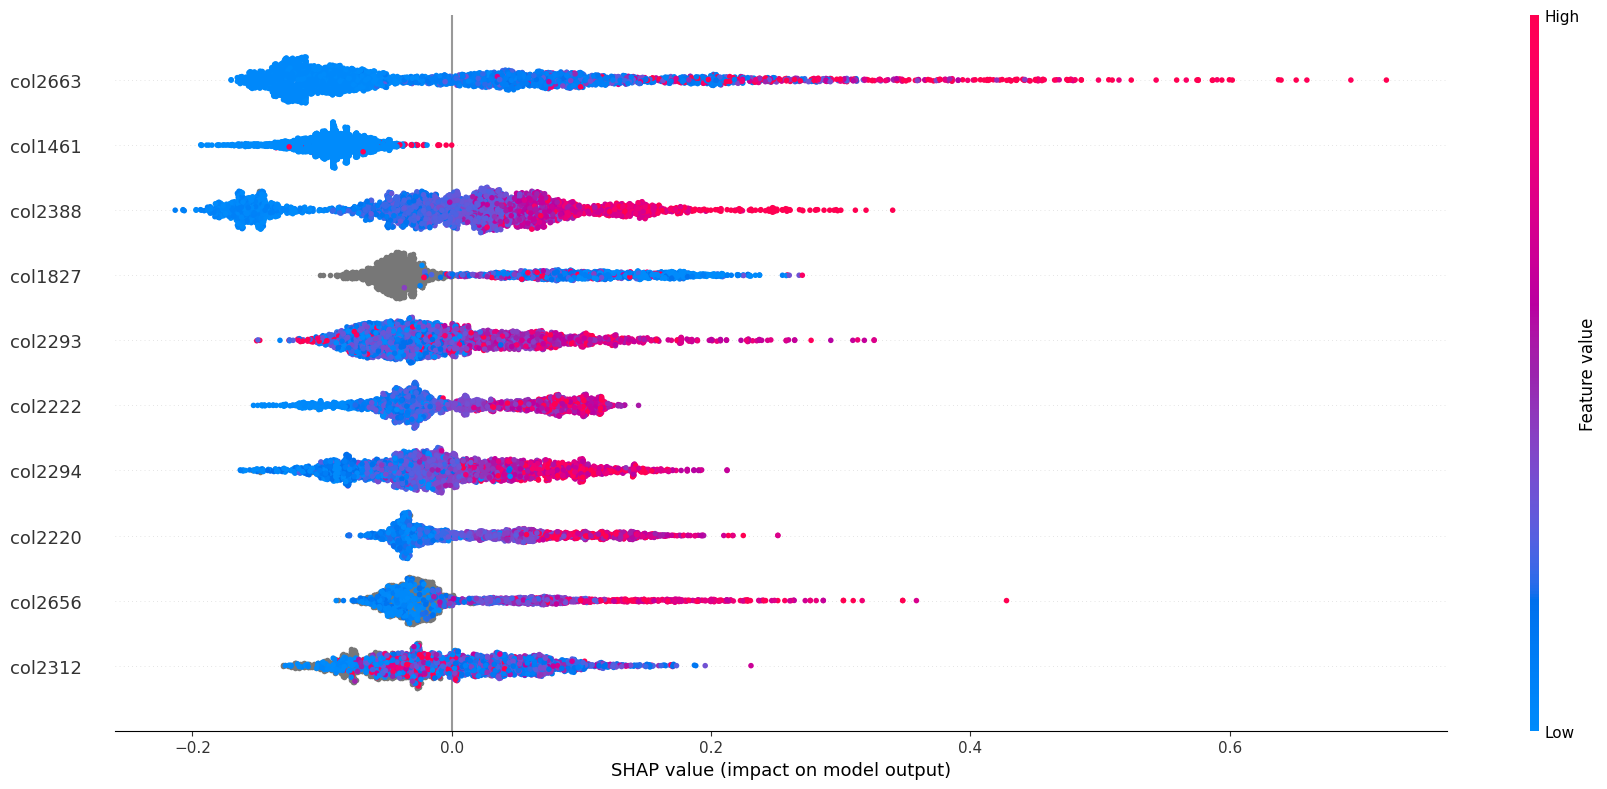

In [55]:
shap_test = shap.TreeExplainer(model).shap_values(df_val.drop(columns = del_col))
shap.summary_plot(shap_test, df_val.drop(columns = del_col), max_display=10, plot_size=(18,8))

In [ ]:

explainer = shap.Explainer(model)
shap_values = explainer(df_val.drop(columns = del_col))
shap.plots.bar(shap_values, max_display=10)

### Поиск гиперпараметров

In [131]:


class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

### Under Samoing 1:2

In [132]:
zeros = pd.concat([df_train, df_val]).loc[pd.concat([df_train, df_val])['target']==0].sample(frac=0.1)
df_train_v2 = pd.concat([df_train, df_val]).loc[pd.concat([df_train, df_val])['target']!=0]
df_train_v2 = pd.concat([df_train_v2, zeros])
display(df_train_v2.shape)
display(df_train_v2['target'].value_counts())

(1455, 360)

target
0    1081
1     374
Name: count, dtype: int64

### Поиск гиперпараметров с помощью Optuna

In [ ]:
 %%time
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    del_col = ['target', 'report_date', 'client_id']
    
    btscv = BlockedTimeSeriesSplit(
        n_splits=4,
        train_size=4,
        test_size=3,
#         col_date = pd.concat([df_train, df_val])['report_date']
        col_date = df_train_v2['report_date']
    )
    
    params = {
        "iterations": 600, #trial.suggest_int("iterations", 500, 1200, step=150),
        "learning_rate": 0.01,#trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
        "depth": trial.suggest_int("depth", 7, 15),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 1, 4),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 200),
    }
    
    model = CatBoostClassifier(
        **params,
        verbose = 0,
        eval_metric='AUC',
        random_seed = 12345
    )
    
    roc_auc = cross_val_score(
        model,
        df_train_v2.drop(columns = del_col),
        df_train_v2['target'],
#         pd.concat([df_train, df_val]).drop(columns = del_col),
#         pd.concat([df_train, df_val])['target'],
        cv=btscv,
        scoring="roc_auc",
        verbose = 3
    ).mean()
    
    return roc_auc


sampler = optuna.samplers.TPESampler(seed=12345)
study = optuna.create_study(study_name="CatBoost", direction="maximize", sampler=sampler)
study.optimize(
    objective,
    n_trials=15,
    n_jobs=-1
)

In [138]:
trial = study.best_trial
trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.7842199930796594], datetime_start=datetime.datetime(2023, 9, 9, 9, 11, 20, 438511), datetime_complete=datetime.datetime(2023, 9, 9, 9, 23, 46, 871063), params={'depth': 8, 'l2_leaf_reg': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=15, log=False, low=7, step=1), 'l2_leaf_reg': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=3, value=None)

In [139]:
params =  study.best_params
print('Best hyperparameters:', params)
print('Best score:', study.best_value)

Best hyperparameters: {'depth': 8, 'l2_leaf_reg': 1}
Best score: 0.7842199930796594


In [141]:
zeros = pd.concat([df_train, df_val]).loc[pd.concat([df_train, df_val])['target']==0].sample(frac=0.1)
df_train_v2 = pd.concat([df_train, df_val]).loc[pd.concat([df_train, df_val])['target']!=0]
df_train_v2 = pd.concat([df_train_v2, zeros])
display(df_train_v2.shape)
display(df_train_v2['target'].value_counts())

(1455, 360)

target
0    1081
1     374
Name: count, dtype: int64

### Сохранение эксперемента в Mlflow

0:	total: 785ms	remaining: 10m 27s
100:	total: 49s	remaining: 5m 39s
200:	total: 1m 38s	remaining: 4m 52s
300:	total: 2m 25s	remaining: 4m 1s
400:	total: 3m 15s	remaining: 3m 14s
500:	total: 4m 4s	remaining: 2m 25s
600:	total: 4m 51s	remaining: 1m 36s
700:	total: 5m 42s	remaining: 48.4s
799:	total: 6m 31s	remaining: 0us


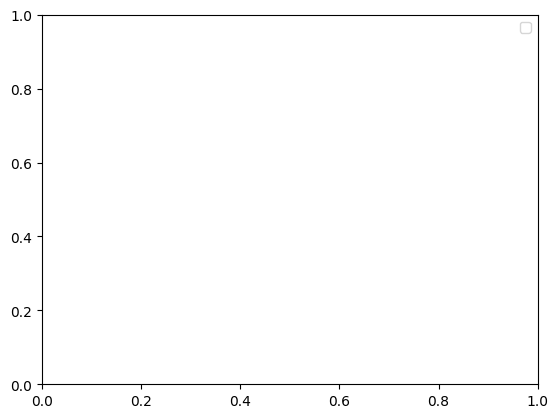

CPU times: user 23min 37s, sys: 1min 53s, total: 25min 30s
Wall time: 6min 33s


In [144]:
%%time
model = CatBoostClassifier(
    **params,
    verbose = 100,
    learning_rate=0.01,
    eval_metric='AUC',
    iterations = 800,
    random_seed = 12345
 #iterations=100,
)

del_col = ['target', 'report_date', 'client_id']

# pool_train = Pool(
#     pd.concat([df_train, df_val]).drop(columns = del_col),
#     label = pd.concat([df_train, df_val])['target'],
#     cat_features = list(df_train.drop(columns =del_col).select_dtypes('object').columns)
# )

pool_train = Pool(
    df_train_v2.drop(columns = del_col),
    label = df_train_v2['target'],
    cat_features = list(df_train_v2.drop(columns =del_col).select_dtypes('object').columns)
)


model.fit(pool_train, plot = False)


In [146]:
# df_test = df_test[df_train_v2.columns]
X_test_good = df_test.drop(columns = del_col)
y_test = df_test['target']

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_good)[:, 1])
print('roc_auc: ',roc_auc)
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_good)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)

roc_auc:  0.8668562720661457
pr_auc:  0.24162319076832947


<BarContainer object of 21 artists>

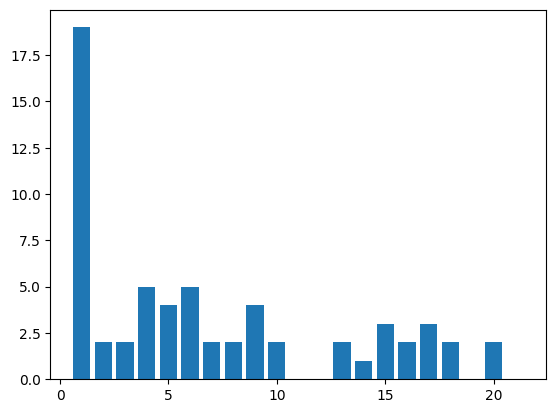

[CV] END ................................ score: (test=0.775) total time=25.1min
[CV] END ................................ score: (test=0.758) total time=42.2min
[CV] END ................................ score: (test=0.758) total time=41.7min
[CV] END ................................ score: (test=0.772) total time=24.5min
[CV] END ................................ score: (test=0.766) total time=88.9min
[CV] END ................................ score: (test=0.776) total time=32.9min
[CV] END ................................ score: (test=0.776) total time=33.1min


[I 2023-09-09 10:59:12,045] Trial 0 finished with value: 0.7768881328024265 and parameters: {'depth': 13, 'l2_leaf_reg': 1}. Best is trial 3 with value: 0.7842199930796594.


[CV] END ................................ score: (test=0.800) total time=28.0min
[CV] END ................................ score: (test=0.769) total time=41.7min


In [147]:
predictions = model.predict(df_test.drop(columns = del_col))

hist_df = pd.DataFrame(
    {
        'target':df_test['target'].values,
        'proba':predictions
    }
)
hist_df = hist_df.sort_values(by='proba', ascending=False)

num_segments = 20
segment_length = len(hist_df) // num_segments

array_21 = [21]*(len(hist_df)-num_segments*segment_length)
hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21

hist_df = hist_df.groupby('segment')['target'].sum()
plt.bar(list(hist_df.index), list(hist_df.values))

### Сохранение эксперемента в Mlflow

In [126]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'Hack test v1')
client = MlflowClient()

In [127]:
import json
    
# Data to be written
columns_dict = {'columns': list(df_test.drop(columns = del_col, axis=1).columns)}
    
with open("/kaggle/working/columns.json", "w") as outfile:
    json.dump(columns_dict, outfile)


# mlflow.log_artifacts('/content/artifacts')

In [128]:
predictions  = model.predict(df_test.drop(columns = del_col))
signature = infer_signature(df_test.drop(columns = del_col, axis=1), predictions)

metrics_to_mlflow = {
    'pr_auc': pr_auc,
    'roc_auc':roc_auc
}

with mlflow.start_run(run_name=f'CatBoost_v2'):
    mlflow.log_params(model.get_params())
#     mlflow.log_param('columns', list(df_test.drop(columns = del_col).columns))
    mlflow.log_metrics(metrics_to_mlflow)
    
    mlflow.sklearn.log_model(
        model,
        signature=signature,
        registered_model_name=f'CatBoost',
        artifact_path='art'
    )
    mlflow.set_tags({'model': 'boosting v2'})
    
    mlflow.log_artifacts('/kaggle/working/columns.json')
    
    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
mlflow.end_run()

2023/09/09 09:02:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://mlflow/6/8d775a48128e4a1db1e70f96d90474d2/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Registered model 'CatBoost' already exists. Creating a new version of this model...
2023/09/09 09:02:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CatBoost, version 3
Created version '3' of model 'CatBoost'.


Model saved in run 8d775a48128e4a1db1e70f96d90474d2


### Отбор фич с помощью BlockedTimeSeriesSplit

In [ ]:
from sklearn.model_selection import BaseCrossValidator

class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

                
def features_engineering(data, n_splits, train_size, test_size):
    all_bad_features = []
    all_good_features = []
    
    # n_splits - сколько сплитов в кроссвалидации
    # train_size - количество уникальных дат в тренировочной выборке
    # test_size - количество уникальных дат в тестовой выборке
    btscv = BlockedTimeSeriesSplit(
        n_splits=n_splits,
        train_size=train_size,
        test_size=test_size,
        col_date = data['report_date']
    )
    
    for train_index, test_index in tqdm(btscv.split(data)):
        print('train')
        display(data.iloc[train_index]['report_date'].unique())
        print('test')
        display(data.iloc[test_index]['report_date'].unique())
        print('-'*100)
        
        # Создаём датасет
#         display()
        X_train = data.iloc[train_index].drop(columns = ['target', 'report_date', 'client_id'])
        y_train = data.iloc[train_index]['target']
        
        X_test = data.iloc[test_index].drop(columns = ['target', 'report_date', 'client_id'])
        y_test = data.iloc[test_index]['target']
    
#         Feature_Selector = BorutaShap(model=model,
#                               importance_measure='shap',
#                               classification=True)
        
#         Feature_Selector.fit(
#             X=X_train,
#             y=y_train,
#             n_trials=10,
#             sample=False,
#             train_or_test = 'test',
#             normalize=False,
#             verbose=True
#         )
#         print(Feature_Selector.features_to_remove)
#         all_bad_features += list(Feature_Selector.features_to_remove)

        # Поиск фичей
        
        
        X_train[X_train.select_dtypes('object').columns] = X_train[X_train.select_dtypes('object').columns].astype(str)
        X_test[X_test.select_dtypes('object').columns] = X_test[X_test.select_dtypes('object').columns].astype(str)
        pool_train = Pool(
            X_train,
            label=y_train,
            cat_features = list(X_train.select_dtypes('object').columns)
        )
        
        pool_test = Pool(
            X_test,
            label=y_test,
            cat_features = list(X_test.select_dtypes('object').columns)
        )
        
        model = CatBoostClassifier(verbose = 0, iterations=100, learning_rate = 0.146267)
        
        feature_selection = model.select_features(
            pool_train,
            eval_set=pool_test,
            features_for_select=list(range(pool_train.num_col())),
            num_features_to_select=12,
            steps=3,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            plot=False,
            verbose=0
        )
        
        # Получаем плохие фичи и заполняем список
        bad_features = (
            feature_selection['eliminated_features_names']
            [
                :feature_selection['loss_graph']['loss_values'].index(min(feature_selection['loss_graph']['loss_values']))
            ]
        )
        all_bad_features += bad_features
        print('bad_features: ',bad_features)
        print('all_bad_features: ', all_bad_features)
        
        
    # Выбиарем плохие вичи, количество которых больше 1
    counter = Counter(all_bad_features)
    all_bad_features = [x for x in counter if counter[x] > 1]
    print('плохие фичи: ', all_bad_features)
    
    data = data.drop(columns = ['target', 'report_date', 'client_id'])
    good_features = data.columns[~data.columns.isin(all_bad_features)]
    
    return good_features

In [ ]:
good_features = features_engineering(df_train, 4, 1, 3)

In [ ]:
good_features

In [ ]:
model = CatBoostClassifier(verbose = 1, iterations=1000, eval_metric='AUC', random_seed = 12345)

del_col = ['target', 'report_date', 'client_id']

pool_train = Pool(
    df_train[good_features],
    label = df_train['target'],
    cat_features = list(df_train[good_features].select_dtypes('object').columns)
)


pool_val = Pool(
    df_val[good_features],
    label = df_val['target'],
    cat_features = list(df_val[good_features].select_dtypes('object').columns)
)

model.fit(pool_train, eval_set=pool_val,plot=True)

In [ ]:
X_test_good = df_test[good_features]
y_test = df_test['target']

print('roc_auc: ',roc_auc_score(y_test, model.predict_proba(X_test_good)[:, 1]))
precision, recall,_ = precision_recall_curve(y_test, model.predict_proba(X_test_good)[:, 1]) 
pr_auc = auc(recall, precision)
print('pr_auc: ',pr_auc)